<a href="https://colab.research.google.com/github/seriman96/Assign/blob/main/RL_Assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this assignment, your goal will be to experiment with some simple bandit learning algorithms by
implementing them from scratch in a variety of scenarios and comparing their performance in terms
of (1) the average per-step reward as well as (2) the proportion of time the optimal action, i.e., the
one with the highest expected reward, is taken.

You should provide a report including plots describing your results and a link to an online repository
with commented and reproducible code. You should also provide a readme file that can make it easy
for anyone to replicate the results in this assignment. Note that modern machine learning conferences
e.g., NeurIPS, and some of the leading journals, e.g. International Journal of Forecasting require
submission of documented code for reproducibility of reported results.

### Part 1

We start by setting up a simple bandit problem with stationary reward distributions. Consider the
so-called k-armed testbed, with k = 10, with normally distributed rewards. Generate a set of ten iid
means μ1, . . . , μ10 from a N(0, 1) distribution and suppose that the arms 1 through 10 have N(μi, 1)
reward distributions where i = 1, . . . , 10.

Our goal will be to study the performance of using the different learning methods we discussed for
bandit algorithms. These are as follows.

• greedy with non-optimistic initial values, i.e. 0.

• epsilon-greedy with different choices of epsilon. Here, you will need to explain how you choose
the value of ϵ. One option is to use pilot runs: small-scale experiments to try a grid of several
settings at low computation cost, tracking the evolution of the rewards curve for each setting to
pick a setting that gives good results.

• optimistic starting values with a greedy approach. You may assume you know the means of each
of the reward distributions to help you set the optimistic initial values. For concreteness, set the
initial action values to the 99.5th percentile of the normal distribution with the highest μi.

• gradient bandit algorithm. Try different learning rates α and determine a good one through
some pilot runs.

In all cases, tiebreaking should be done by choosing an arm uniformly at random. Run each
algorithm for 2000 time steps. Repeat for a total of 1000 simulations and report (1) the average
reward acquired by the algorithm at each time step, averaged over the 1000 simulations and (2) the
percentage of time the optimal action is taken by the algorithm at each time step. Note that each of
the 1000 simulations muse use a separate, independent random stream.

Comment on which of the methods performs the best. Can you comment why? What did you do
to tune each of the methods?

In [ ]:
# !pip install tqdm

In [ ]:
# Multi-Armed Bandit Algorithms Implementation for 10-Armed Testbed
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [ ]:
np.random.seed(42)

k = 10
runs = 1000
time_steps = 2000

In [ ]:
# Function to generate k reward distributions
def generate_bandits():
    means = np.random.normal(0, 1, k)
    best_action = np.argmax(means)
    return means, best_action

In [ ]:
# Greedy with Q_0 = 0 (non-optimistic)
def run_greedy(runs, time_steps):
    rewards = np.zeros((runs, time_steps))
    optimal_actions = np.zeros((runs, time_steps))

    for run in range(runs):
        means, best_action = generate_bandits()
        q_values = np.zeros(k)  # Non-optimistic initial values (Q = 0)
        counts = np.zeros(k)

        for t in range(time_steps):
            action = np.argmax(q_values)  # Pure greedy selection
            reward = np.random.normal(means[action], 1)

            counts[action] += 1
            q_values[action] += (reward - q_values[action]) / counts[action]

            rewards[run, t] = reward
            optimal_actions[run, t] = (action == best_action)

    return rewards, optimal_actions

# Epsilon-Greedy (parameterized)
def run_epsilon_greedy(runs, time_steps, epsilon):
    rewards = np.zeros((runs, time_steps))
    optimal_actions = np.zeros((runs, time_steps))

    for run in range(runs):
        means, best_action = generate_bandits()
        q_values = np.zeros(k)
        counts = np.zeros(k)

        for t in range(time_steps):
            if np.random.rand() < epsilon:
                action = np.random.choice(k)
            else:
                action = np.argmax(q_values)

            reward = np.random.normal(means[action], 1)
            counts[action] += 1
            q_values[action] += (reward - q_values[action]) / counts[action]

            rewards[run, t] = reward
            optimal_actions[run, t] = (action == best_action)

    return rewards, optimal_actions

op_value=0
# Optimistic Greedy with 99.5 percentile
def run_optimistic_greedy(runs, time_steps):
    rewards = np.zeros((runs, time_steps))
    optimal_actions = np.zeros((runs, time_steps))

    for run in range(runs):
        means, best_action = generate_bandits()
        mu_max = np.max(means)
        optimistic_value = norm.ppf(0.995, loc=mu_max, scale=1) #percent-point function (PPF), also known as the inverse cumulative distributio
        op_value = optimistic_value

        q_values = np.ones(k) * optimistic_value  # Optimistic initial values
        counts = np.zeros(k)

        for t in range(time_steps):
            action = np.argmax(q_values)
            reward = np.random.normal(means[action], 1)
            counts[action] += 1
            q_values[action] += (reward - q_values[action]) / counts[action]

            rewards[run, t] = reward
            optimal_actions[run, t] = (action == best_action)

    return rewards, optimal_actions

# Gradient Bandit Algorithm
def run_gradient_bandit(runs, time_steps, alpha=0.1):
    rewards = np.zeros((runs, time_steps))
    optimal_actions = np.zeros((runs, time_steps))

    for run in range(runs):
        means, best_action = generate_bandits()
        preferences = np.zeros(k)
        average_reward = 0

        for t in range(time_steps):
            probs = np.exp(preferences) / np.sum(np.exp(preferences))
            action = np.random.choice(k, p=probs)
            reward = np.random.normal(means[action], 1)

            average_reward += (reward - average_reward) / (t + 1)

            for a in range(k):
                if a == action:
                    preferences[a] += alpha * (reward - average_reward) * (1 - probs[a])
                else:
                    preferences[a] -= alpha * (reward - average_reward) * probs[a]

            rewards[run, t] = reward
            optimal_actions[run, t] = (action == best_action)

    return rewards, optimal_actions

In [ ]:
# Pilot for epsilon
def epsilon_pilot(epsilons=[0.01, 0.05, 0.1, 0.2, 0.3], pilot_runs=200, pilot_steps=500, smooth_window=50):
    plt.figure(figsize=(12, 10))

    print("=== Average Reward per ε ===")
    # Plot 1: Average Reward
    plt.subplot(2, 1, 1)
    for eps in epsilons:
        rewards, _ = run_epsilon_greedy(pilot_runs, pilot_steps, eps)
        avg_rewards = rewards.mean(axis=0)
        overall_avg = avg_rewards.mean()
        smoothed_avg = avg_rewards[-smooth_window:].mean()
        print(f"ε = {eps:.2f} -> Overall Avg = {overall_avg:.4f}, Last {smooth_window} Avg = {smoothed_avg:.4f}")
        plt.plot(avg_rewards, label=f"ϵ = {eps}")
    plt.title("Pilot Run: Epsilon-Greedy - Average Reward")
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()

    print("\n=== % Optimal Action per ε ===")
    # Plot 2: % Optimal Action
    plt.subplot(2, 1, 2)
    for eps in epsilons:
        _, eps_opt = run_epsilon_greedy(pilot_runs, pilot_steps, eps)
        avg_opt = eps_opt.mean(axis=0)
        overall_opt = avg_opt.mean() * 100
        smoothed_opt = avg_opt[-smooth_window:].mean() * 100
        print(f"ε = {eps:.2f} -> Overall Optimal = {overall_opt:.2f}%, Last {smooth_window} = {smoothed_opt:.2f}%")
        plt.plot(eps_opt.mean(axis=0), label=f"ϵ = {eps}")
    plt.title("Pilot Run: Epsilon-Greedy - % Optimal Action")
    plt.xlabel("Time Step")
    plt.ylabel("% Optimal Action")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
# Pilot for gradient bandit
def gradient_pilot(alphas=[0.01, 0.05, 0.1, 0.2], pilot_runs=200, pilot_steps=500, smooth_window=50):
    plt.figure(figsize=(12, 10))

    print("=== Average Reward per α ===")
    # Plot 1: Average Reward
    plt.subplot(2, 1, 1)
    for alpha in alphas:
        rewards, _ = run_gradient_bandit(pilot_runs, pilot_steps, alpha=alpha)
        avg_rewards = rewards.mean(axis=0)
        overall_avg = avg_rewards.mean()
        smoothed_avg = avg_rewards[-smooth_window:].mean()
        print(f"α = {alpha:.2f} -> Overall Avg = {overall_avg:.4f}, Last {smooth_window} Avg = {smoothed_avg:.4f}")
        plt.plot(avg_rewards, label=f"α = {alpha}")
    plt.title("Pilot Run: Gradient Bandit - Average Reward")
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()

    print("\n=== % Optimal Action per α ===")
    # Plot 2: % Optimal Action
    plt.subplot(2, 1, 2)
    for alpha in alphas:
        _, grad_opt = run_gradient_bandit(pilot_runs, pilot_steps, alpha=alpha)
        overall_opt = grad_opt.mean() * 100
        smoothed_opt = grad_opt[-smooth_window:].mean() * 100
        print(f"α = {alpha:.2f} -> Overall Optimal = {overall_opt:.2f}%, Last {smooth_window} = {smoothed_opt:.2f}%")
        plt.plot(grad_opt.mean(axis=0), label=f"α = {alpha}")
    plt.title("Pilot Run: Gradient Bandit - % Optimal Action")
    plt.xlabel("Time Step")
    plt.ylabel("% Optimal Action")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


In [ ]:
# Plotting utility
def plot_results(results, labels, title):
    plt.figure(figsize=(12, 6))
    for res, label in zip(results, labels):
        plt.plot(np.mean(res, axis=0), label=label)
    plt.xlabel("Time Step")
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

Running pilot study for epsilon-greedy...
=== Average Reward per ε ===
ε = 0.01 -> Overall Avg = 1.0774, Last 50 Avg = 1.1762
ε = 0.05 -> Overall Avg = 1.2701, Last 50 Avg = 1.3984
ε = 0.10 -> Overall Avg = 1.2073, Last 50 Avg = 1.2911
ε = 0.20 -> Overall Avg = 1.0770, Last 50 Avg = 1.1400
ε = 0.30 -> Overall Avg = 0.9623, Last 50 Avg = 1.0104

=== % Optimal Action per ε ===
ε = 0.01 -> Overall Optimal = 44.29%, Last 50 = 54.62%
ε = 0.05 -> Overall Optimal = 54.89%, Last 50 = 68.42%
ε = 0.10 -> Overall Optimal = 63.32%, Last 50 = 74.86%
ε = 0.20 -> Overall Optimal = 65.30%, Last 50 = 72.98%
ε = 0.30 -> Overall Optimal = 57.31%, Last 50 = 64.79%


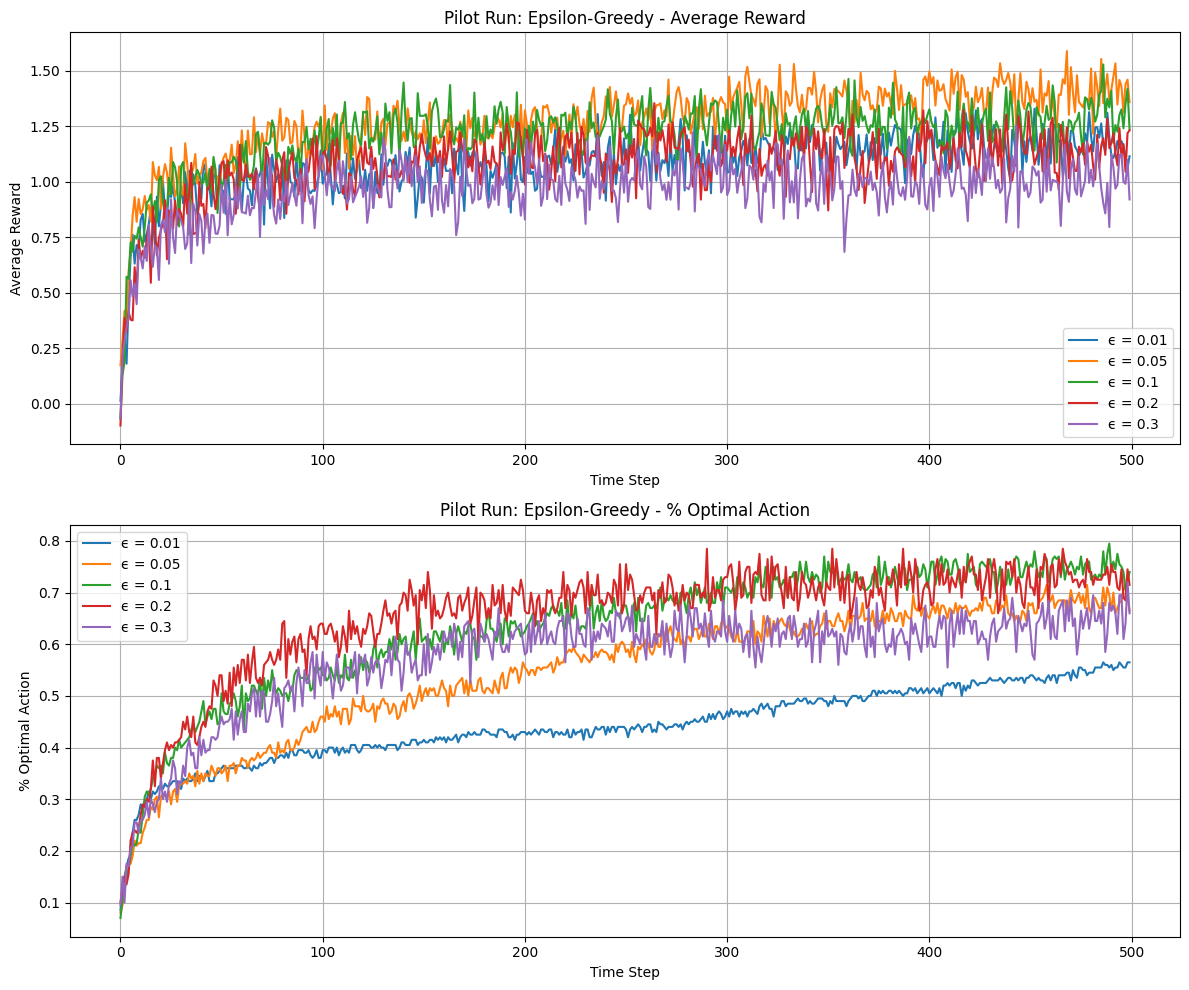

Running pilot study for gradient bandit...
=== Average Reward per α ===
α = 0.01 -> Overall Avg = 0.2427, Last 50 Avg = 0.5018
α = 0.05 -> Overall Avg = 1.0064, Last 50 Avg = 1.4306
α = 0.10 -> Overall Avg = 1.2227, Last 50 Avg = 1.4863
α = 0.20 -> Overall Avg = 1.3042, Last 50 Avg = 1.4778

=== % Optimal Action per α ===
α = 0.01 -> Overall Optimal = 16.79%, Last 50 = 15.96%
α = 0.05 -> Overall Optimal = 52.33%, Last 50 = 55.36%
α = 0.10 -> Overall Optimal = 63.52%, Last 50 = 62.25%
α = 0.20 -> Overall Optimal = 65.14%, Last 50 = 63.90%


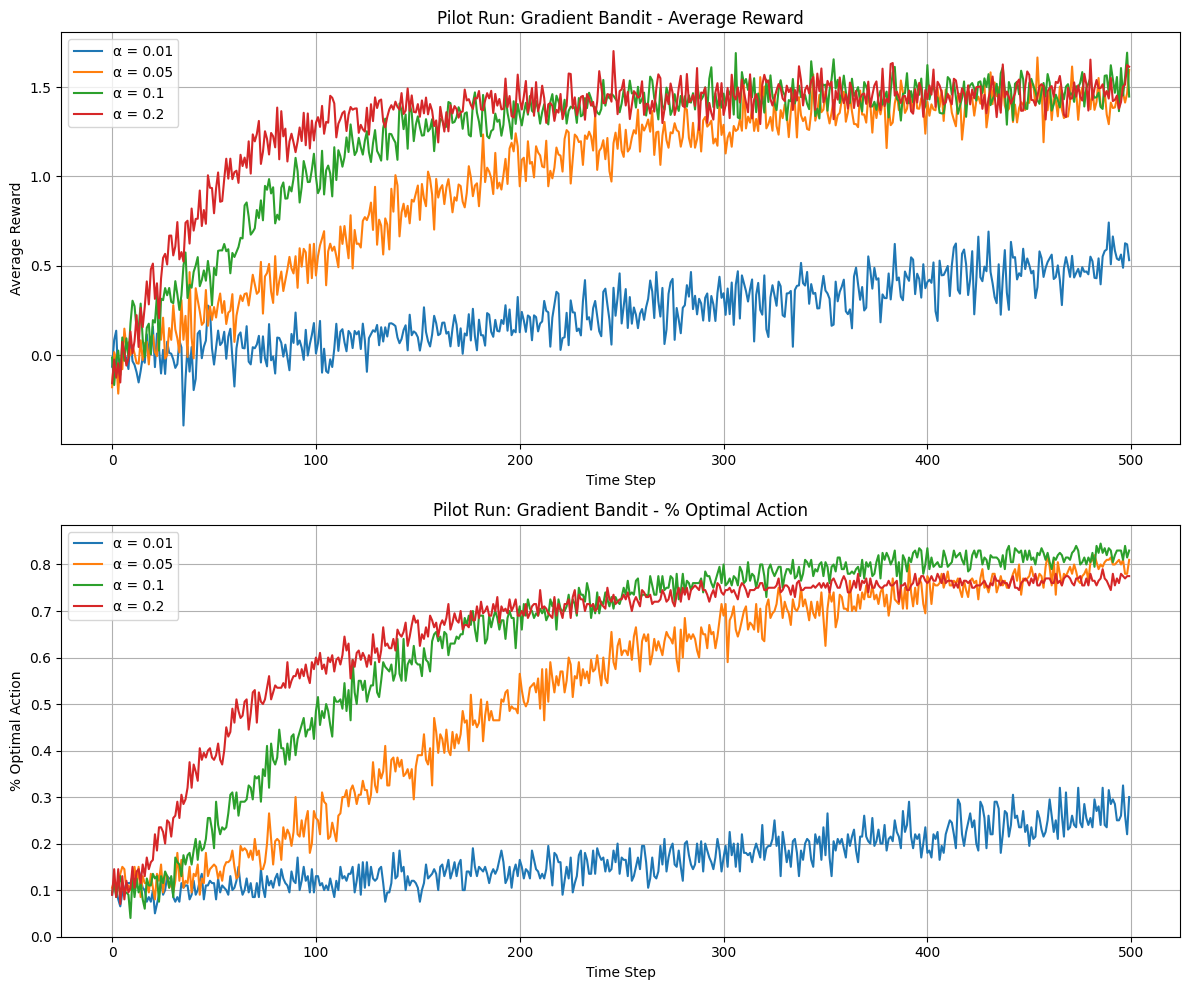

Running main experiments...


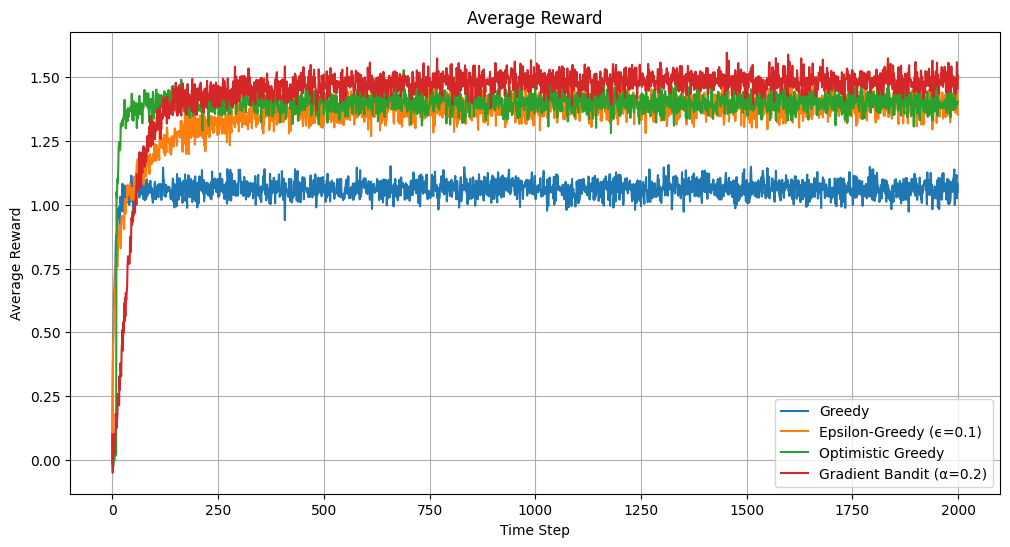

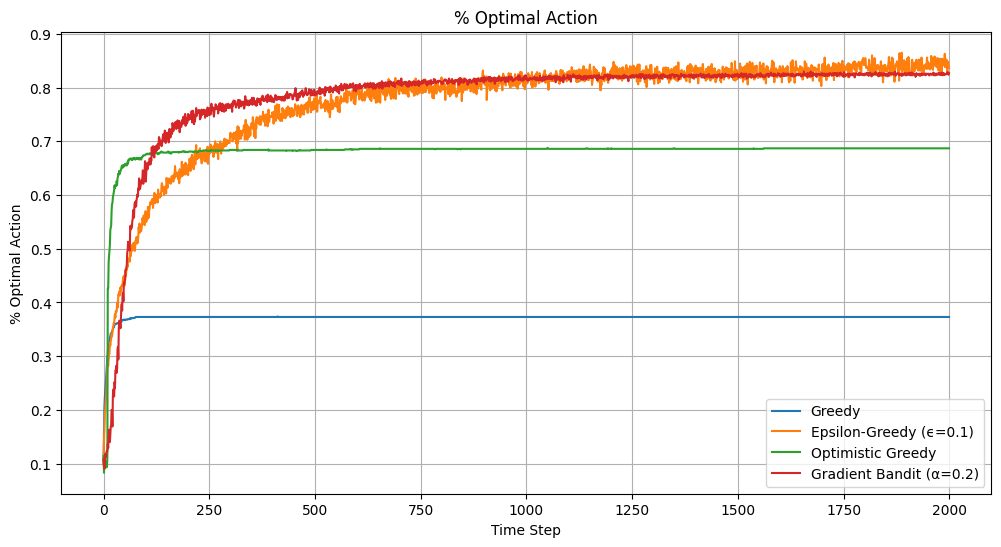

In [ ]:
# Run full experiments
if __name__ == '__main__':
    print("Running pilot study for epsilon-greedy...")
    epsilon_pilot()

    print("Running pilot study for gradient bandit...")
    gradient_pilot()

    print("Running main experiments...")
    greedy_rewards, greedy_opt = run_greedy(runs, time_steps)
    eps_rewards, eps_opt = run_epsilon_greedy(runs, time_steps, epsilon=0.1)  # Based on pilot result
    opt_rewards, opt_opt = run_optimistic_greedy(runs, time_steps)
    grad_rewards, grad_opt = run_gradient_bandit(runs, time_steps, alpha=0.2)  # Based on pilot result

    plot_results(
        [greedy_rewards, eps_rewards, opt_rewards, grad_rewards],
        ["Greedy", "Epsilon-Greedy (ϵ=0.1)", "Optimistic Greedy", "Gradient Bandit (α=0.2)"],
        "Average Reward"
    )

    plot_results(
        [greedy_opt, eps_opt, opt_opt, grad_opt],
        ["Greedy", "Epsilon-Greedy (ϵ=0.1)", "Optimistic Greedy", "Gradient Bandit (α=0.2)"],
        "% Optimal Action"
    )


### 2. Part 2

Now consider non-stationary modifications of the problem above. In the real world, changes to rewards
can be gradual, abrupt or a combination of both. Think of the brightness of an image changing
gradually, as daylight does, or abruptly, as if a light switch is turned on.

#### 2.1 Gradual changes

Try applying (1) a drift to each μi you generated above to make it time-variable
μi,t = μi,t−1 + ϵi,t

where ϵi,t is iid N(0, 0.01^2) and separately (2) a mean-reverting change
μi,t = κμi,t−1 + ϵi,t

where κ = 0.5, ϵi,t is iid N(0, 0.01^2), and μi,1 = μi. Note that we use the mean-variance parametrization
of the normal distribution throughout.

#### 2.2 Abrupt changes

At t = 501 randomly permute the means corresponding to each of the reward distributions. Explore
what happens when you keep running the algorithms as-is. Also, check what happens with a hard
reset, i.e., when you reset all action values to 0 at t = 501. In other words, you have foreknowledge of
the changepoint.

Compare action-value based methods with the gradient bandit algorithm on this problem in terms
of the average per-step reward and the proportion of time the optimal action is taken on 2000 time
steps. Like above, use an average over 1000 simulations. Do not forget to use the same 10 seeds for
the noise processes driving the drift on each μi and the same random permutation for each of the
simulations, else the 1000 simulations will not be comparable to one another (think why?). You may
use pilot runs to get an idea of the sort of rewards a method produces to set the parameters before
running the 1000 repetitions.

In [ ]:
SEEDS = np.random.RandomState(42).randint(0, 100000, 1000)
class NonstationaryBandit:
    def __init__(self, k=10, steps=time_steps, drift_std=0.01, mean_reverting=False, abrupt_change=False, hard_reset=False):
        self.k = k
        self.steps = steps
        self.drift_std = drift_std
        self.mean_reverting = mean_reverting
        self.abrupt_change = abrupt_change
        self.hard_reset = hard_reset
        self.kappa = 0.5
        self.reset()

    def reset(self):
        self.means = np.random.normal(0, 1, self.k)
        self.initial_means = self.means.copy()
        self.mean_history = [self.means.copy()]

    def update_means(self):
        noise = np.random.normal(0, self.drift_std, self.k)
        if self.mean_reverting:
            self.means = self.kappa * self.means + noise
        else:
            self.means += noise
        self.mean_history.append(self.means.copy())

    def permute_means(self):
        np.random.seed(42)
        self.means = self.means[np.random.permutation(self.k)]

    def get_reward(self, action):
        return np.random.normal(self.means[action], 1)

    def get_optimal_action(self):
        return np.argmax(self.means)

In [ ]:
def run_algorithm(bandit, algorithm, alpha=None, epsilon=None, optimistic_value=None):
    Q = np.zeros(bandit.k) if optimistic_value is None else np.ones(bandit.k) * optimistic_value
    H = np.zeros(bandit.k)
    action_counts = np.zeros(bandit.k)
    avg_rewards = []
    optimal_action_taken = []
    probs = np.ones(bandit.k) / bandit.k
    baseline = 0

    for t in range(bandit.steps):
        if bandit.abrupt_change and t == 501:
            bandit.permute_means()
            if bandit.hard_reset:
                Q = np.zeros(bandit.k)
                H = np.zeros(bandit.k)
                action_counts = np.zeros(bandit.k)
                baseline = 0

        if algorithm == "greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif algorithm == "epsilon-greedy":
            if np.random.rand() < epsilon:
                action = np.random.randint(bandit.k)
            else:
                action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif algorithm == "optimistic-greedy":
            action = np.random.choice(np.flatnonzero(Q == Q.max()))
        elif algorithm == "gradient-bandit":
            exp_prefs = np.exp(H - np.max(H))
            probs = exp_prefs / np.sum(exp_prefs)
            action = np.random.choice(bandit.k, p=probs)

        reward = bandit.get_reward(action)
        optimal = bandit.get_optimal_action()
        avg_rewards.append(reward)
        optimal_action_taken.append(1 if action == optimal else 0)

        action_counts[action] += 1
        if algorithm == "gradient-bandit":
            baseline += (reward - baseline) / (t + 1)
            for a in range(bandit.k):
                if a == action:
                    H[a] += alpha * (reward - baseline) * (1 - probs[a])
                else:
                    H[a] -= alpha * (reward - baseline) * probs[a]
        else:
            Q[action] += (reward - Q[action]) / action_counts[action]

        bandit.update_means()

    return np.array(avg_rewards), np.array(optimal_action_taken)

In [ ]:
def simulate(method, alpha=None, epsilon=None, optimistic_value=None, drift=True, mean_revert=False, abrupt=False, reset=False):
    avg_rewards = np.zeros(2000)
    optimal_action_probs = np.zeros(2000)
    seeds=SEEDS

    for s in tqdm(seeds):
        np.random.seed(s)
        bandit = NonstationaryBandit(
            drift_std=0.01,
            mean_reverting=mean_revert,
            abrupt_change=abrupt,
            hard_reset=reset
        )
        r, o = run_algorithm(bandit, method, alpha=alpha, epsilon=epsilon, optimistic_value=optimistic_value)
        avg_rewards += r
        optimal_action_probs += o

    avg_rewards /= 1000
    optimal_action_probs /= 1000
    return avg_rewards, optimal_action_probs

In [ ]:
def plot_results(results, title):
    plt.figure(figsize=(12, 5))
    for label, (rewards, _) in results.items():
        plt.plot(rewards, label=f"{label} (Reward)")
    plt.title(f"Average Reward - {title}")
    plt.xlabel("Steps")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 5))
    for label, (_, opt_probs) in results.items():
        plt.plot(opt_probs, label=f"{label} (% Optimal)")
    plt.title(f"% Optimal Action - {title}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal Action")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def pilot_epsilon_nonstationary(env_type, smooth_window=50):
    epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
    pilot_runs = 200
    pilot_steps = 500
    plt.figure(figsize=(12, 10))

    print(f"=== Avg Reward per ε ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 1)
    for eps in epsilons:
        rewards = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            r, _ = run_algorithm(bandit, "epsilon-greedy", epsilon=eps)
            rewards.append(r[:pilot_steps])
        rewards = np.array(rewards)
        avg_rewards = rewards.mean(axis=0)
        overall_avg = avg_rewards.mean()
        smoothed_avg = avg_rewards[-smooth_window:].mean()
        print(f"ε = {eps:.2f} -> Overall Avg = {overall_avg:.4f}, Last {smooth_window} Avg = {smoothed_avg:.4f}")
        plt.plot(np.mean(rewards, axis=0), label=f"ε = {eps}")
    plt.title(f"Epsilon-Greedy Avg Reward - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("Avg Reward")
    plt.legend()

    print(f"\n=== % Optimal Action per ε ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 2)
    for eps in epsilons:
        opts = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            _, o = run_algorithm(bandit, "epsilon-greedy", epsilon=eps)
            opts.append(o[:pilot_steps])
        opts = np.array(opts)
        avg_opt = opts.mean(axis=0)
        overall_opt = avg_opt.mean() * 100
        smoothed_opt = avg_opt[-smooth_window:].mean() * 100
        print(f"ε = {eps:.2f} -> Overall Optimal = {overall_opt:.2f}%, Last {smooth_window} = {smoothed_opt:.2f}%")
        plt.plot(np.mean(opts, axis=0), label=f"ε = {eps}")
    plt.title(f"Epsilon-Greedy % Optimal - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def pilot_gradient_nonstationary(env_type, smooth_window=50):
    alphas = [0.01, 0.05, 0.1, 0.2]
    pilot_runs = 200
    pilot_steps = 500
    plt.figure(figsize=(12, 10))

    print(f"=== Avg Reward per α ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 1)
    for alpha in alphas:
        rewards = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            r, _ = run_algorithm(bandit, "gradient-bandit", alpha=alpha)
            rewards.append(r[:pilot_steps])
        rewards = np.array(rewards)
        avg_rewards = rewards.mean(axis=0)
        overall_avg = avg_rewards.mean()
        smoothed_avg = avg_rewards[-smooth_window:].mean()
        print(f"α = {alpha:.2f} -> Overall Avg = {overall_avg:.4f}, Last {smooth_window} Avg = {smoothed_avg:.4f}")
        plt.plot(np.mean(rewards, axis=0), label=f"α = {alpha}")
    plt.title(f"Gradient Bandit Avg Reward - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("Avg Reward")
    plt.legend()

    print(f"\n=== % Optimal Action per α ({env_type.capitalize()} Environment) ===")
    plt.subplot(2, 1, 2)
    for alpha in alphas:
        opts = []
        for _ in range(pilot_runs):
            bandit = NonstationaryBandit(mean_reverting=(env_type == "mean"), abrupt_change=(env_type == "abrupt"))
            _, o = run_algorithm(bandit, "gradient-bandit", alpha=alpha)
            opts.append(o[:pilot_steps])
        opts = np.array(opts)
        avg_opt = opts.mean(axis=0)
        overall_opt = avg_opt.mean() * 100
        smoothed_opt = avg_opt[-smooth_window:].mean() * 100
        print(f"α = {alpha:.2f} -> Overall Optimal = {overall_opt:.2f}%, Last {smooth_window} = {smoothed_opt:.2f}%")
        plt.plot(np.mean(opts, axis=0), label=f"α = {alpha}")
    plt.title(f"Gradient Bandit % Optimal - {env_type.capitalize()}")
    plt.xlabel("Steps")
    plt.ylabel("% Optimal")
    plt.legend()
    plt.tight_layout()
    plt.show()

Running pilot study for epsilon-greedy...
=== Avg Reward per ε (Drift Environment) ===
ε = 0.01 -> Overall Avg = 1.0653, Last 50 Avg = 1.1369
ε = 0.05 -> Overall Avg = 1.2885, Last 50 Avg = 1.4257
ε = 0.10 -> Overall Avg = 1.2741, Last 50 Avg = 1.3674
ε = 0.20 -> Overall Avg = 1.1690, Last 50 Avg = 1.2616
ε = 0.30 -> Overall Avg = 1.0823, Last 50 Avg = 1.1470

=== % Optimal Action per ε (Drift Environment) ===
ε = 0.01 -> Overall Optimal = 47.26%, Last 50 = 52.07%
ε = 0.05 -> Overall Optimal = 52.65%, Last 50 = 66.58%
ε = 0.10 -> Overall Optimal = 61.10%, Last 50 = 67.22%
ε = 0.20 -> Overall Optimal = 59.03%, Last 50 = 64.33%
ε = 0.30 -> Overall Optimal = 54.42%, Last 50 = 62.70%


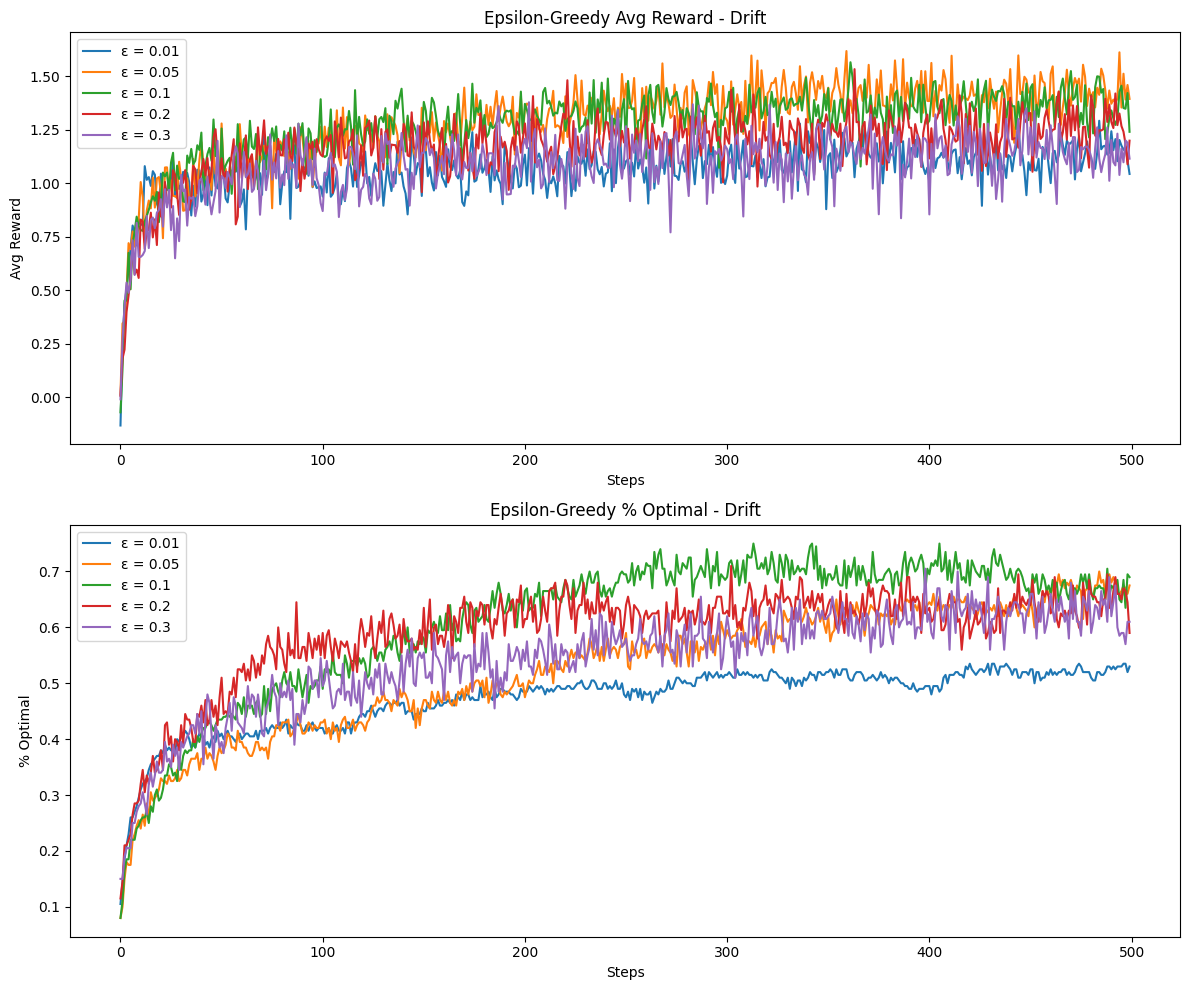

=== Avg Reward per ε (Mean Environment) ===
ε = 0.01 -> Overall Avg = 0.0022, Last 50 Avg = 0.0186
ε = 0.05 -> Overall Avg = 0.0031, Last 50 Avg = 0.0081
ε = 0.10 -> Overall Avg = -0.0064, Last 50 Avg = -0.0022
ε = 0.20 -> Overall Avg = 0.0058, Last 50 Avg = -0.0032
ε = 0.30 -> Overall Avg = 0.0007, Last 50 Avg = 0.0039

=== % Optimal Action per ε (Mean Environment) ===
ε = 0.01 -> Overall Optimal = 9.91%, Last 50 = 9.44%
ε = 0.05 -> Overall Optimal = 10.15%, Last 50 = 10.07%
ε = 0.10 -> Overall Optimal = 9.94%, Last 50 = 9.30%
ε = 0.20 -> Overall Optimal = 9.95%, Last 50 = 10.19%
ε = 0.30 -> Overall Optimal = 10.23%, Last 50 = 9.66%


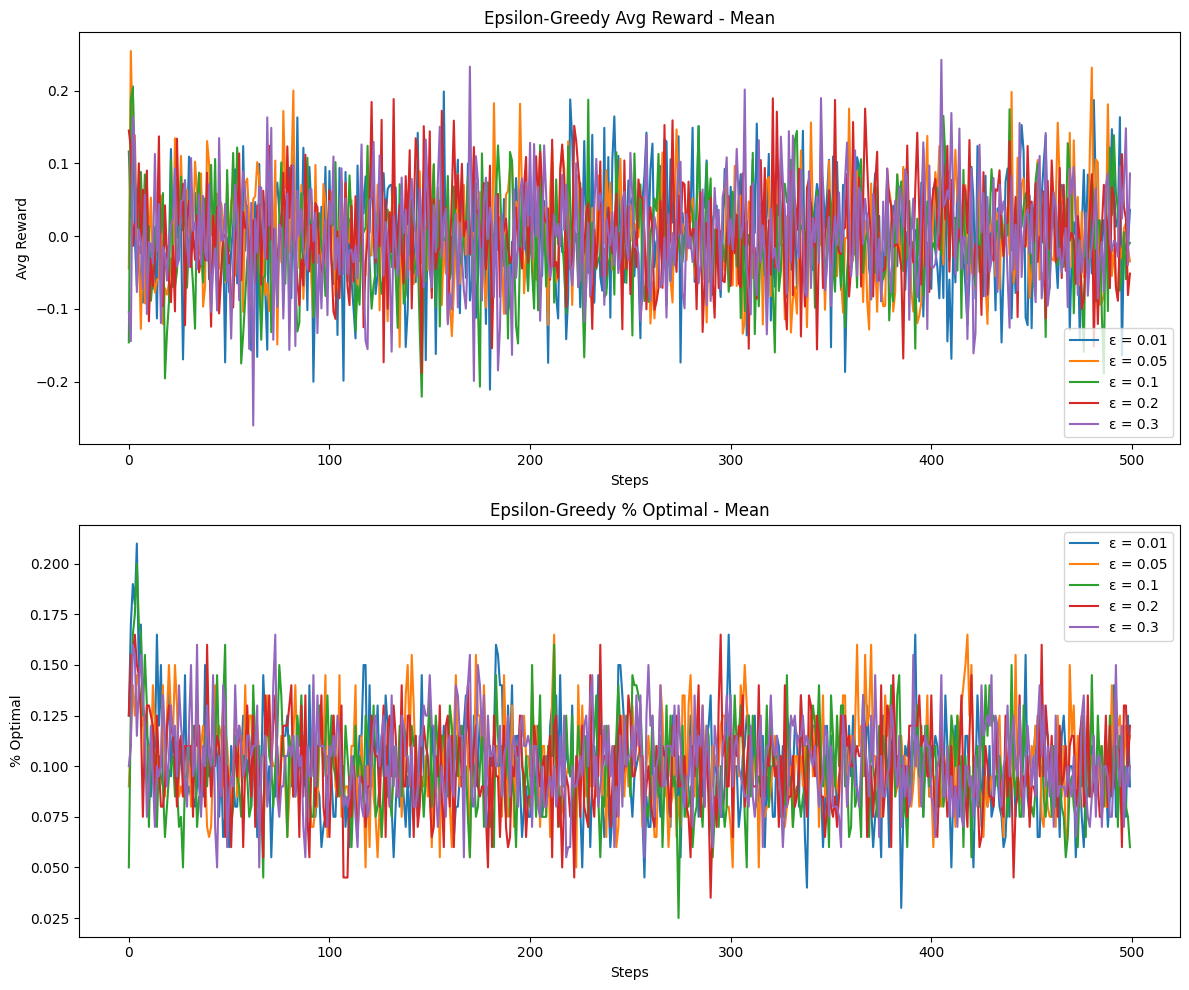

=== Avg Reward per ε (Abrupt Environment) ===
ε = 0.01 -> Overall Avg = 0.6643, Last 50 Avg = 1.1977
ε = 0.05 -> Overall Avg = 1.5053, Last 50 Avg = 1.4431
ε = 0.10 -> Overall Avg = 0.1622, Last 50 Avg = 0.6822
ε = 0.20 -> Overall Avg = 0.9560, Last 50 Avg = 1.1223
ε = 0.30 -> Overall Avg = 1.0543, Last 50 Avg = 1.0652

=== % Optimal Action per ε (Abrupt Environment) ===
ε = 0.01 -> Overall Optimal = 0.00%, Last 50 = 0.00%
ε = 0.05 -> Overall Optimal = 95.52%, Last 50 = 99.50%
ε = 0.10 -> Overall Optimal = 52.40%, Last 50 = 94.00%
ε = 0.20 -> Overall Optimal = 3.79%, Last 50 = 8.38%
ε = 0.30 -> Overall Optimal = 55.50%, Last 50 = 70.00%


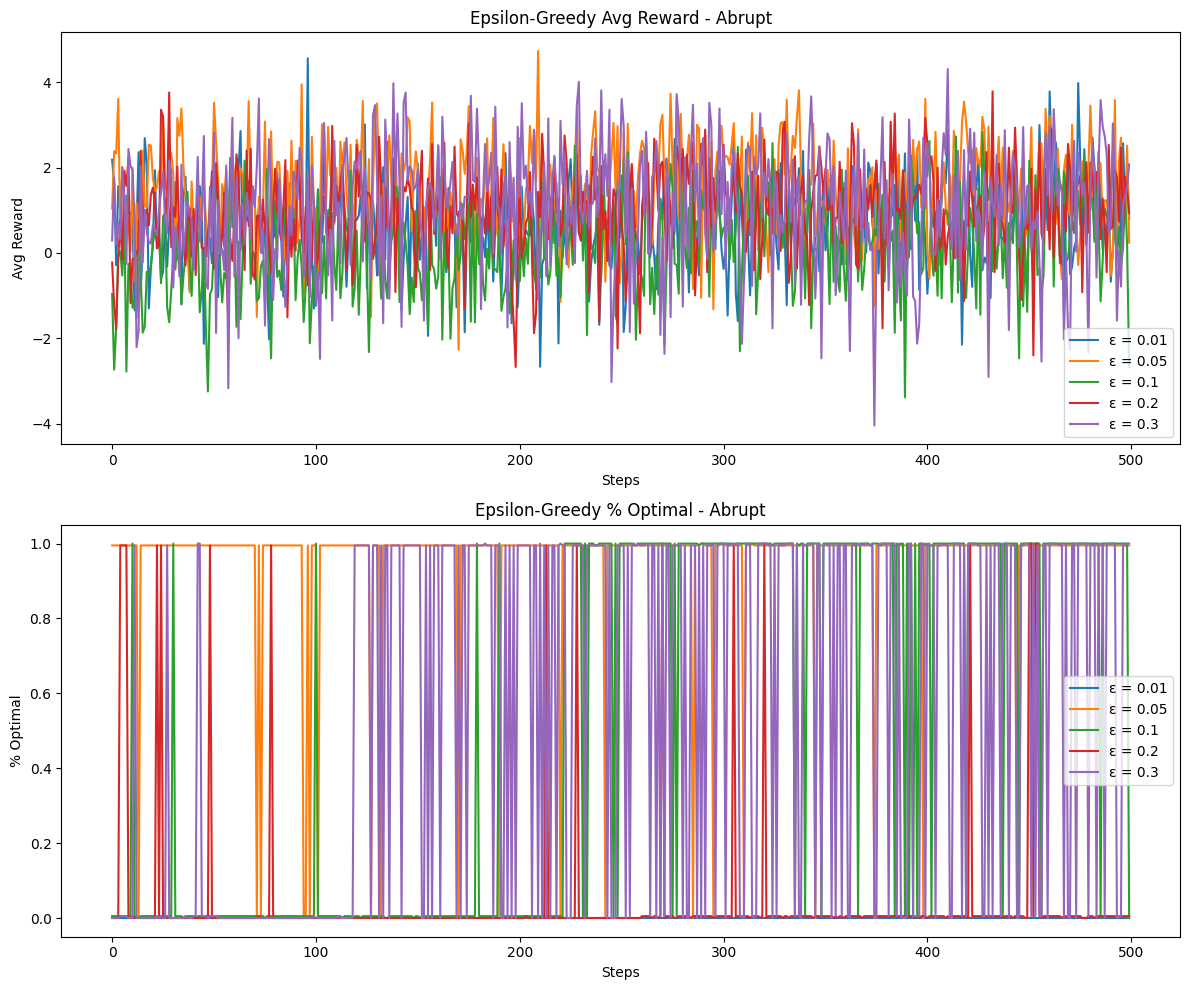

Running pilot study for gradient bandit...
=== Avg Reward per α (Drift Environment) ===
α = 0.01 -> Overall Avg = 0.2327, Last 50 Avg = 0.4887
α = 0.05 -> Overall Avg = 0.9784, Last 50 Avg = 1.3996
α = 0.10 -> Overall Avg = 1.2302, Last 50 Avg = 1.4973
α = 0.20 -> Overall Avg = 1.2657, Last 50 Avg = 1.4298

=== % Optimal Action per α (Drift Environment) ===
α = 0.01 -> Overall Optimal = 16.81%, Last 50 = 26.01%
α = 0.05 -> Overall Optimal = 50.45%, Last 50 = 73.46%
α = 0.10 -> Overall Optimal = 62.84%, Last 50 = 76.72%
α = 0.20 -> Overall Optimal = 66.11%, Last 50 = 74.73%


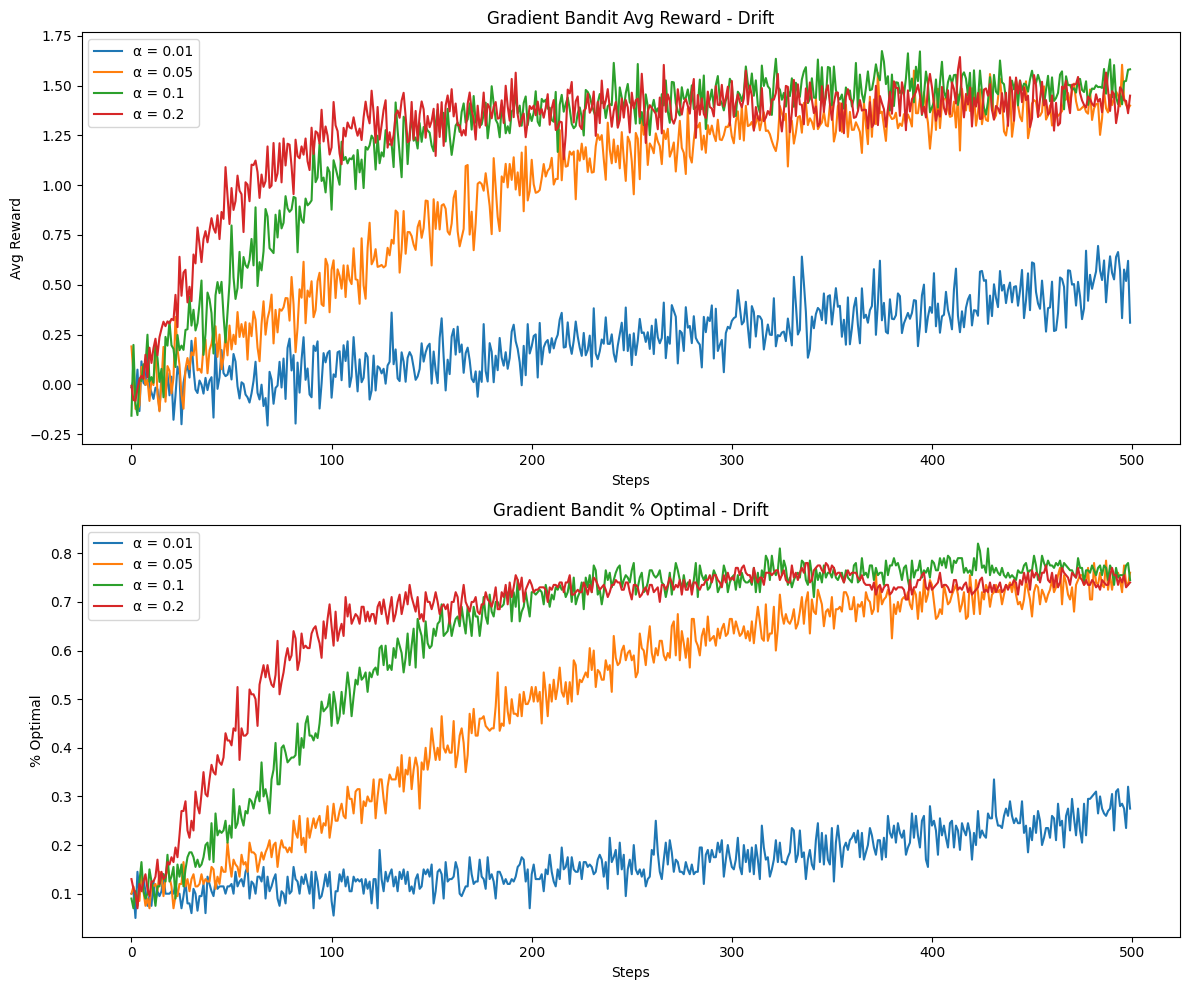

=== Avg Reward per α (Mean Environment) ===
α = 0.01 -> Overall Avg = 0.0008, Last 50 Avg = 0.0050
α = 0.05 -> Overall Avg = -0.0003, Last 50 Avg = -0.0016
α = 0.10 -> Overall Avg = -0.0018, Last 50 Avg = -0.0183
α = 0.20 -> Overall Avg = 0.0013, Last 50 Avg = 0.0100

=== % Optimal Action per α (Mean Environment) ===
α = 0.01 -> Overall Optimal = 9.91%, Last 50 = 9.84%
α = 0.05 -> Overall Optimal = 9.81%, Last 50 = 9.70%
α = 0.10 -> Overall Optimal = 10.10%, Last 50 = 10.31%
α = 0.20 -> Overall Optimal = 10.12%, Last 50 = 9.97%


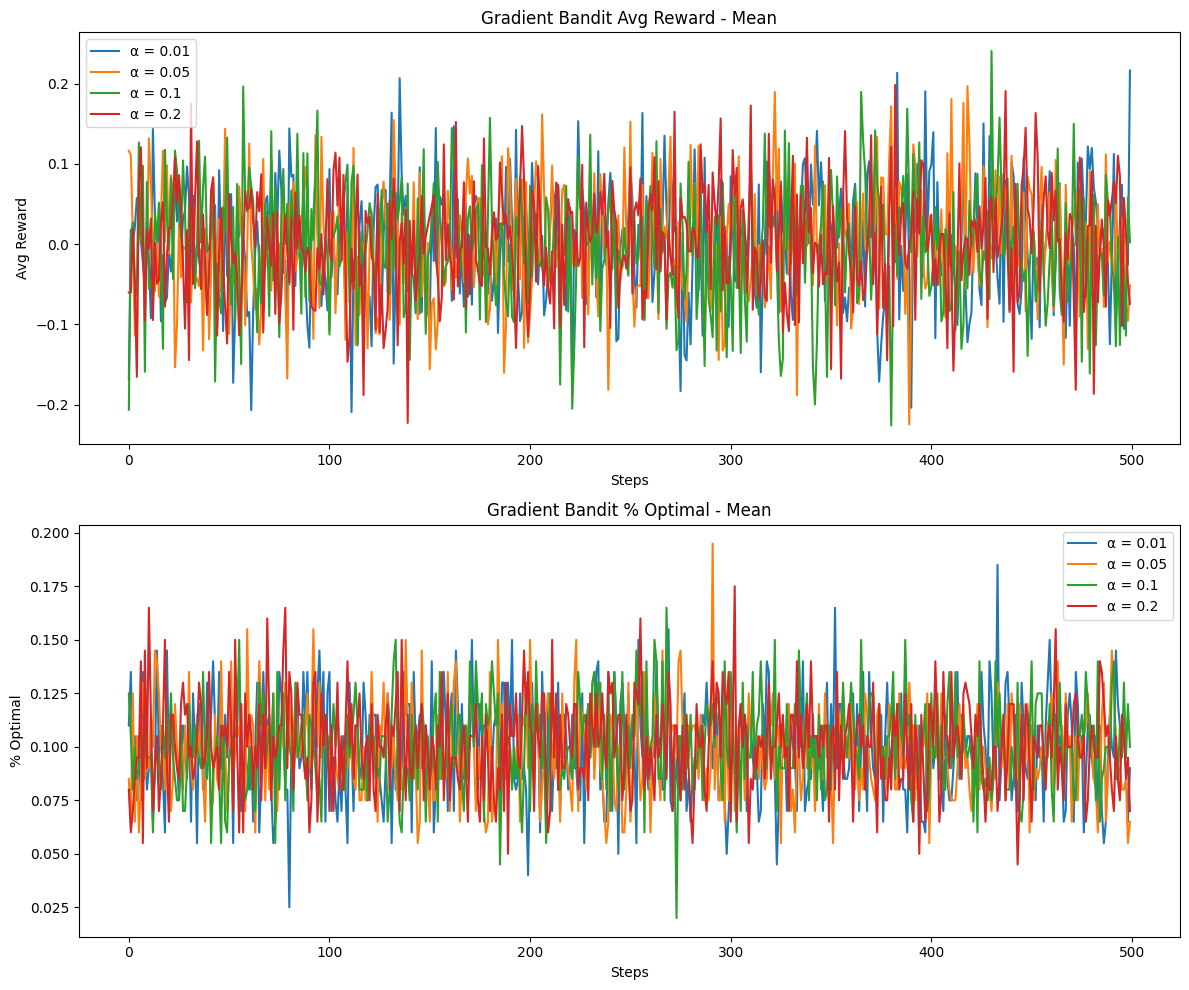

=== Avg Reward per α (Abrupt Environment) ===
α = 0.01 -> Overall Avg = 0.5526, Last 50 Avg = 1.3289
α = 0.05 -> Overall Avg = 1.6238, Last 50 Avg = 2.3829
α = 0.10 -> Overall Avg = 1.7635, Last 50 Avg = 2.3829
α = 0.20 -> Overall Avg = 1.8521, Last 50 Avg = 2.3829

=== % Optimal Action per α (Abrupt Environment) ===
α = 0.01 -> Overall Optimal = 13.60%, Last 50 = 22.00%
α = 0.05 -> Overall Optimal = 70.60%, Last 50 = 98.00%
α = 0.10 -> Overall Optimal = 66.00%, Last 50 = 98.00%
α = 0.20 -> Overall Optimal = 69.20%, Last 50 = 98.00%


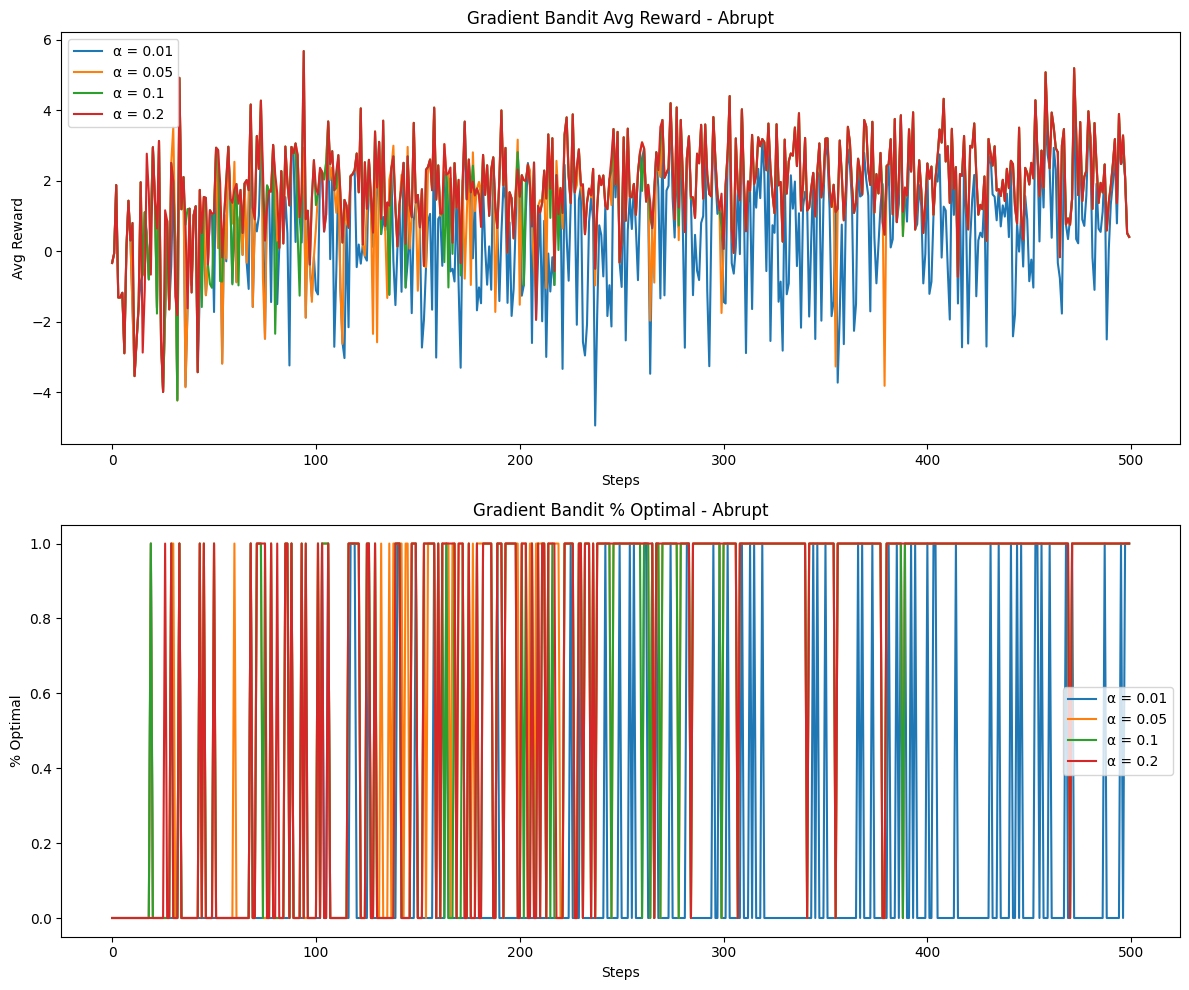

In [ ]:
print("Running pilot study for epsilon-greedy...")
pilot_epsilon_nonstationary("drift")
pilot_epsilon_nonstationary("mean")
pilot_epsilon_nonstationary("abrupt")

print("Running pilot study for gradient bandit...")
pilot_gradient_nonstationary("drift")
pilot_gradient_nonstationary("mean")
pilot_gradient_nonstationary("abrupt")


100%|██████████| 1000/1000 [02:11<00:00,  7.59it/s]


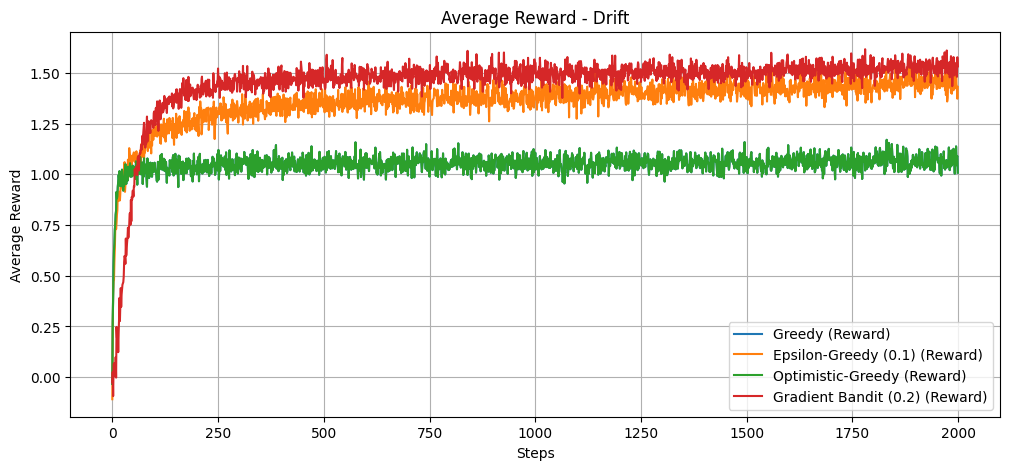

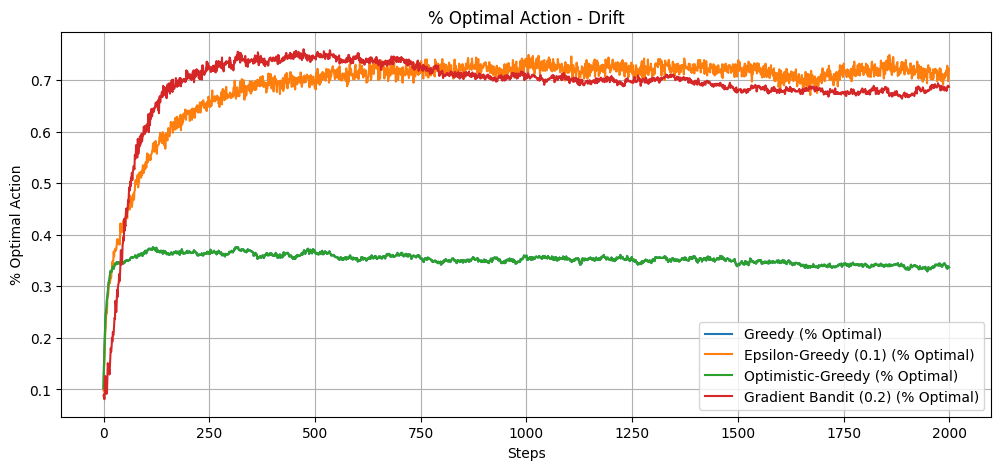

100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


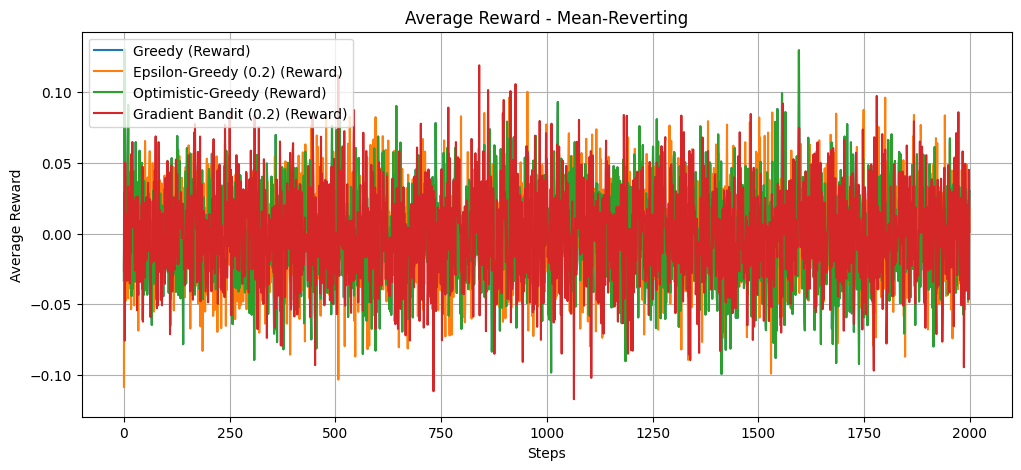

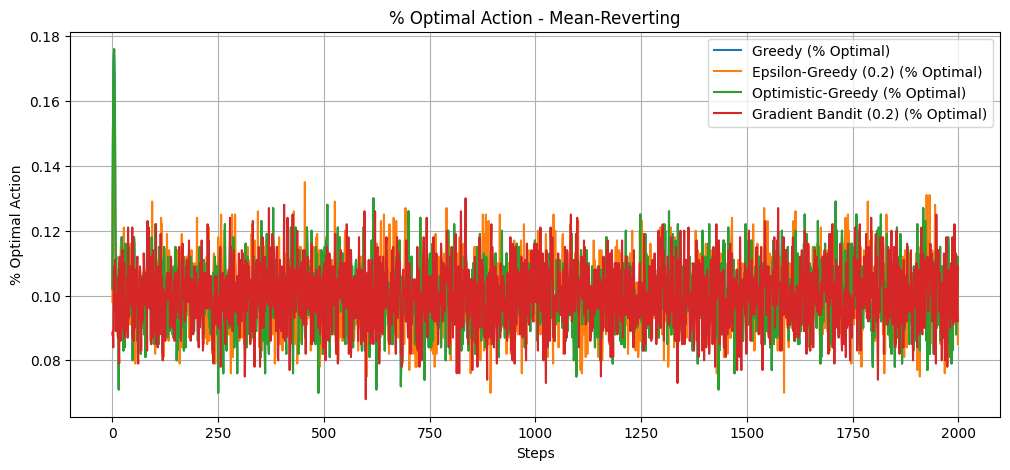

100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


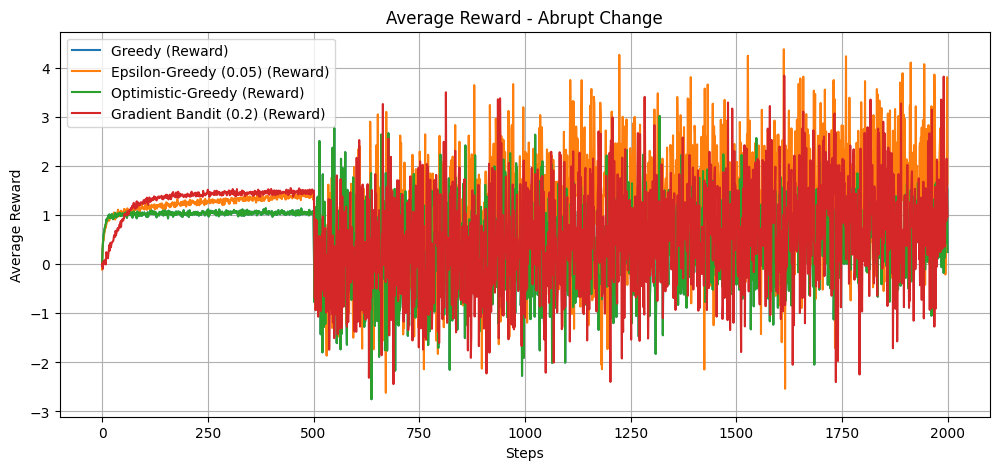

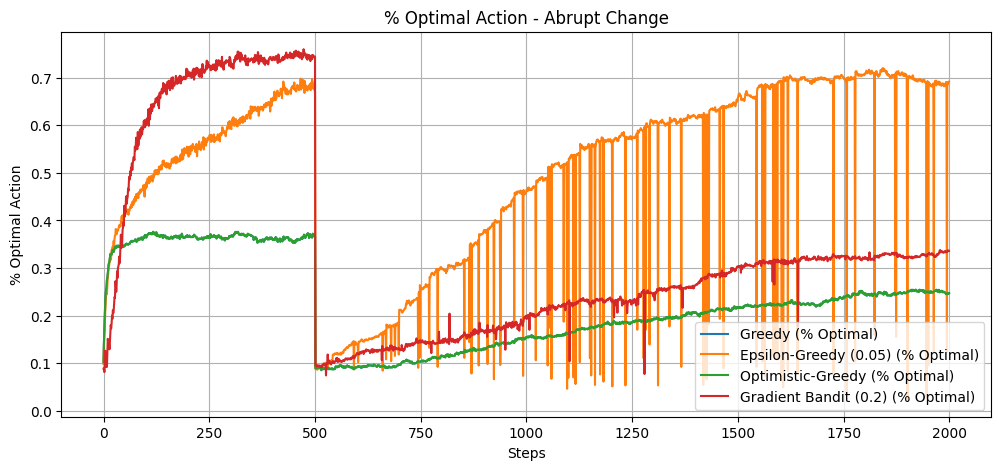

100%|██████████| 1000/1000 [02:17<00:00,  7.28it/s]


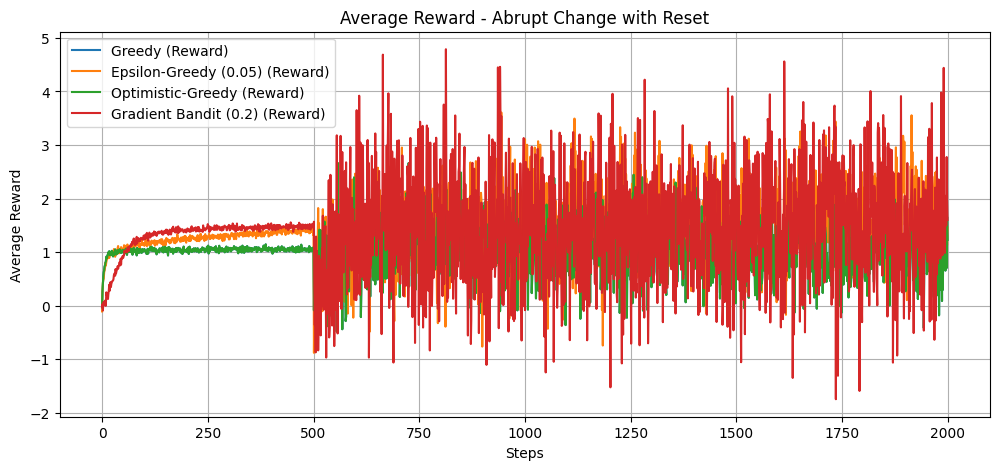

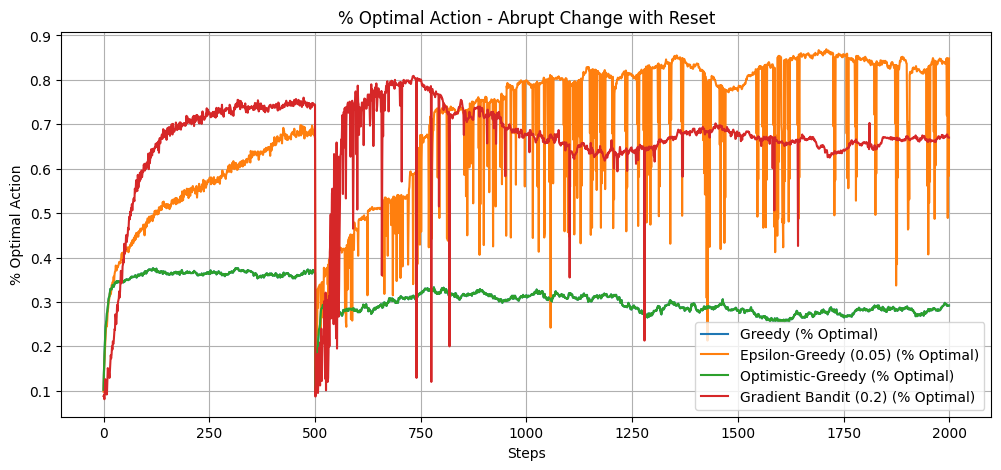

In [ ]:
# Simulations
results_drift = {
    "Greedy": simulate("greedy"),
    "Epsilon-Greedy (0.1)": simulate("epsilon-greedy", epsilon=0.1),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2)
}
plot_results(results_drift, "Drift")

results_mean = {
    "Greedy": simulate("greedy", mean_revert=True),
    "Epsilon-Greedy (0.2)": simulate("epsilon-greedy", epsilon=0.2, mean_revert=True),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value, mean_revert=True),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2, mean_revert=True)
}
plot_results(results_mean, "Mean-Reverting")

results_abrupt = {
    "Greedy": simulate("greedy", abrupt=True),
    "Epsilon-Greedy (0.05)": simulate("epsilon-greedy", epsilon=0.05, abrupt=True),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value, abrupt=True),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2, abrupt=True)
}
plot_results(results_abrupt, "Abrupt Change")

results_abrupt_reset = {
    "Greedy": simulate("greedy", abrupt=True, reset=True),
    "Epsilon-Greedy (0.05)": simulate("epsilon-greedy", epsilon=0.05, abrupt=True, reset=True),
    "Optimistic-Greedy": simulate("optimistic-greedy", optimistic_value=op_value, abrupt=True, reset=True),
    "Gradient Bandit (0.2)": simulate("gradient-bandit", alpha=0.2, abrupt=True, reset=True)
}
plot_results(results_abrupt_reset, "Abrupt Change with Reset")